# 임포트

In [1]:
import math
import os
import ast

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from geopy.geocoders import Nominatim

%matplotlib inline
from IPython.display import display


# 데이터 확인

In [2]:
data = pd.read_csv('airbnbmark1.csv', dtype={
        'host_acceptance_rate':str,
        'weekly_price':str,
        'monthly_price':str,
        'license':str,
        'jurisdiction_names':str,
        }
    )
data.shape

(153254, 106)

In [3]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20200212052319,2020-02-12,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20200212052319,2020-02-13,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.69
2,5099,https://www.airbnb.com/rooms/5099,20200212052319,2020-02-12,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59


In [4]:
data.describe()
# 아래 정보들은 object dtype을 가진 데이터는 포함하지 않으므로 주의
# 결측치가 있음을 확인 가능

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,latitude,longitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.532540e+05,1.532540e+05,0.0,0.0,0.0,1.532540e+05,153050.000000,153050.000000,153254.000000,153254.000000,...,119312.000000,119231.000000,119279.000000,119222.000000,119222.000000,153254.000000,153254.00000,153254.000000,153254.000000,122289.000000
mean,2.225193e+07,2.020021e+13,NaN,NaN,NaN,8.297160e+07,21.179536,21.179536,40.729086,-73.950828,...,9.279025,9.736109,9.742310,9.593817,9.383830,7.609159,5.85804,1.515921,0.137295,1.336353
std,1.293543e+07,8.583871e+07,NaN,NaN,NaN,9.537811e+07,146.649053,146.649053,0.054865,0.047666,...,1.083864,0.744320,0.760339,0.749935,0.934644,32.970765,32.41745,6.984752,1.287762,1.648065
min,2.060000e+03,2.020010e+13,NaN,NaN,NaN,2.259000e+03,0.000000,0.000000,40.499790,-74.244420,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.00000,0.000000,0.000000,0.000000
25%,1.065982e+07,2.020010e+13,NaN,NaN,NaN,9.368118e+06,1.000000,1.000000,40.689700,-73.983160,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.00000,0.000000,0.000000,0.190000
50%,2.203224e+07,2.020021e+13,NaN,NaN,NaN,3.763366e+07,1.000000,1.000000,40.723360,-73.955150,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.00000,0.000000,0.000000,0.690000
75%,3.432368e+07,2.020031e+13,NaN,NaN,NaN,1.365562e+08,2.000000,2.000000,40.763090,-73.934010,...,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.00000,1.000000,0.000000,2.000000
max,4.289272e+07,2.020031e+13,NaN,NaN,NaN,3.414399e+08,2345.000000,2345.000000,40.914290,-73.708400,...,10.000000,10.000000,10.000000,10.000000,10.000000,302.000000,302.00000,133.000000,34.000000,66.360000


In [5]:
# DtypeWarning: Columns (27,61,62,94,95) have mixed types.
# Specify dtype option on import or set low_memory=False.
data.iloc[:, [27,61,62,94,95]]

,host_acceptance_rate,weekly_price,monthly_price,license,jurisdiction_names
0,38%,"$1,995.00",NaN,NaN,NaN
1,96%,$575.00,"$2,100.00",NaN,NaN
2,71%,NaN,NaN,NaN,NaN
3,67%,NaN,NaN,NaN,NaN
4,100%,$470.00,NaN,NaN,NaN
...,...,...,...,...,...
153249,100%,NaN,NaN,NaN,NaN
153250,99%,NaN,NaN,NaN,NaN
153251,NaN,NaN,NaN,NaN,NaN
153252,100%,NaN,NaN,NaN,NaN


# 전처리

## 분석

### 전처리 또는 drop이 필요한 것들


* 하위 항목 분리 필요
  * host_verifications
  * amenities
* classify 필요
  * cancellation_pollicy
  
* 종속성 확인(street)
  * street
  * neightborhood
  * neighborhood_cleansed
  * neighborhood_group
  * city
  * state
  * zipcode
  * market
  * smart_location 종속성 확인

* $ 표기 제거
  * price
  * weekly_price
  * monthly_price
  * security_deposit
  * cleaning_fee
  * extra_people
* % 표기 제거
  * host_acceptance_rate
* 적합성 판단 필요
  * calendar_updated
  * is_location_exact 수상한 컬럼

* 날자 표기 통일
  * first_review
  * last_review
  
* 자연어 관련 column
  * name
  * summary
  * space
  * description
  * neighborhood_overview
  * notes
  * transit
  * access
  * interaction
  * house_rules
  * host_about

### drop한 것들과 그 사유

* 모든 값이 동일
  * experience_offered; 모든 값이 null
  * country; US
  * country_code; US
  * state
  * requires_license; f
  * is_business_travel_ready; f
  * has_availability; t
* 얻을 정보 없음
  * scrape_id
  * last_scraped; scrape 관련 메타정보, 얻을 정보가 없음.
  * calendar_last_scraped; scrape 관련 메타정보, 얻을 정보가 없음
  * url
    * listing_url
    * airbnb_url
    * thumbnail_url
    * medium_url
    * picture_url
    * xl_pictuere_url
    * host_thumbnail_url
    * host_picture_url
    * host_url
  * host_name
* 종속 & 너무 많은 결측치
  * jurisdiction_names

## Drop

In [6]:
column_to_drop = [
    'listing_url',
    'scrape_id',
    'last_scraped',
    'calendar_last_scraped',
    'experiences_offered',
    'thumbnail_url',
    'medium_url',
    'picture_url',
    'xl_picture_url',
    'host_thumbnail_url',
    'host_picture_url',
    'host_url',
    'host_name',
    'country',
    'country_code',
    'requires_license',
    'is_business_travel_ready',
    'jurisdiction_names',
    'has_availability'
    ]
for column in column_to_drop:
    try:
        data = data.drop(column, axis='columns')
    except KeyError as e:
        print(e)

In [7]:
column_nlp = [
    'name',
    'summary',
    'space',
    'description',
    'neighborhood_overview',
    'notes',
    'transit',
    'access',
    'interaction',
    'house_rules',
    'host_about'
]
for column in column_nlp:
    try:
        data = data.drop(column, axis='columns')
    except KeyError as e:
        print(e)

In [8]:
data.head()

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,2845,2008-09-09,"New York, New York, United States",within a day,50%,38%,f,Midtown,6.0,...,NaN,f,strict_14_with_grace_period,t,t,2,2,0,0,0.39
1,3831,4869,2008-12-07,"New York, New York, United States",within an hour,100%,96%,f,Clinton Hill,1.0,...,NaN,f,moderate,f,f,1,1,0,0,4.69
2,5099,7322,2009-02-02,"New York, New York, United States",NaN,NaN,71%,f,Flatiron District,1.0,...,NaN,f,moderate,t,t,1,1,0,0,0.59
3,5121,7356,2009-02-03,"New York, New York, United States",NaN,NaN,67%,f,Bedford-Stuyvesant,1.0,...,NaN,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,8967,2009-03-03,"New York, New York, United States",within a few hours,90%,100%,f,Hell's Kitchen,1.0,...,NaN,f,strict_14_with_grace_period,f,f,1,0,1,0,3.53


## 데이터 결측치/타입/오류 확인 및 제거

### 데이터 결측치 확인

In [9]:
count = len(data)
df_na_count = data.isna().sum()
df_na_rate = df_na_count / count
df_na = pd.concat([df_na_rate, df_na_count], axis=1)
df_na.columns = ['rate', 'count_na']
df_na['count_not_na'] = count - df_na['count_na']
df_na[df_na.count_na != 0].sort_values(by='rate', ascending=False)

,rate,count_na,count_not_na
license,0.999439,153168,86
square_feet,0.992490,152103,1151
monthly_price,0.906808,138972,14282
weekly_price,0.892655,136803,16451
host_acceptance_rate,0.517898,79370,73884
host_response_time,0.361746,55439,97815
host_response_rate,0.361746,55439,97815
security_deposit,0.343371,52623,100631
review_scores_location,0.222063,34032,119222
review_scores_value,0.222063,34032,119222


### 너무 적은 데이터 제거
* license, square_Feet

In [10]:
data_not_na = data.loc[:, ['license', 'square_feet']]
data_not_na = data_not_na[~data_not_na.license.isna() | ~data_not_na.square_feet.isna()]
pd.concat([data_not_na.head(),data_not_na.tail()])

,license,square_feet
1,NaN,500.0
11,NaN,500.0
15,NaN,750.0
19,NaN,800.0
20,NaN,700.0
152960,46-4091213,NaN
152961,46-4091213,NaN
152962,46-4091213,NaN
152965,46-4091213,NaN
152966,46-4091213,NaN


In [11]:
data_not_na[~data_not_na.license.isna()]['license'].value_counts()

81-1092926                   12
46-4091213                   11
35-2593481                    9
83-2444556                    9
20-5909724                    9
20-5163086                    8
47-3886130                    6
11-3461723                    6
20-0976501                    6
HUTB-162541                   3
City registration pending     3
47-4365717                    2
83-1780849                    2
Name: license, dtype: int64

In [12]:
data_not_na[~data_not_na.square_feet.isna()]['square_feet'].value_counts()

0.0       93
1000.0    74
700.0     73
800.0     69
500.0     57
          ..
96.0       2
194.0      1
11.0       1
484.0      1
65.0       1
Name: square_feet, Length: 97, dtype: int64

In [13]:
column_to_drop = ['license, square_feet']
for column in column_to_drop:
    try:
        data = data.drop(column, axis=1)
    except KeyError as e:
        print(e)

"['license, square_feet'] not found in axis"


### 데이터 중복 확인

In [14]:
data.count()

id                                              153254
host_id                                         153254
host_since                                      153050
host_location                                   152632
host_response_time                               97815
                                                 ...  
calculated_host_listings_count                  153254
calculated_host_listings_count_entire_homes     153254
calculated_host_listings_count_private_rooms    153254
calculated_host_listings_count_shared_rooms     153254
reviews_per_month                               122289
Length: 76, dtype: int64

In [15]:
df_overlap_rate = pd.DataFrame(columns=['name', 'n_unique', 'not_na'])
for column in data:
    new_row = pd.Series({"name":column, "n_unique":data[column].value_counts().count(), "not_na":data[column].count(), "dtype":data[column].dtype}, name=column)
    df_overlap_rate.loc[len(df_overlap_rate)] = new_row
df_overlap_rate["average_count_per_unique"] = df_overlap_rate["not_na"] / df_overlap_rate["n_unique"]
df_overlap_rate[df_overlap_rate.n_unique < 50].sort_values(by='n_unique')

,name,n_unique,not_na,average_count_per_unique
7,host_is_superhost,2,153050,76525.0
12,host_has_profile_pic,2,153050,76525.0
13,host_identity_verified,2,153050,76525.0
70,require_guest_phone_verification,2,153254,76627.0
69,require_guest_profile_picture,2,153254,76627.0
67,instant_bookable,2,153254,76627.0
25,is_location_exact,2,153254,76627.0
4,host_response_time,4,97815,24453.75
27,room_type,4,153254,38313.5
32,bed_type,5,153254,30650.8


In [16]:
for index, (name, n_unique, not_na, cpu) in df_overlap_rate.sort_values(by='n_unique').head(15).iterrows():
    print(name, n_unique, data[name].unique())

require_guest_phone_verification 2 ['t' 'f']
require_guest_profile_picture 2 ['t' 'f']
host_identity_verified 2 ['t' 'f' nan]
host_has_profile_pic 2 ['t' 'f' nan]
instant_bookable 2 ['f' 't']
host_is_superhost 2 ['f' 't' nan]
is_location_exact 2 ['f' 't']
host_response_time 4 ['within a day' 'within an hour' nan 'within a few hours'
 'a few days or more']
room_type 4 ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
bed_type 5 ['Real Bed' 'Futon' 'Pull-out Sofa' 'Airbed' 'Couch']
neighbourhood_group_cleansed 5 ['Manhattan' 'Brooklyn' 'Queens' 'Staten Island' 'Bronx']
cancellation_policy 6 ['strict_14_with_grace_period' 'moderate' 'flexible' 'strict'
 'super_strict_60' 'super_strict_30']
state 8 ['NY' nan 'ny' 'MP' 'CA' 'NJ' 'New York' 'Ny' 'FL']
review_scores_location 8 [10.  9. nan  8.  7.  6.  2.  4.  5.]
review_scores_accuracy 9 [ 9. 10.  8. nan  7.  2.  6.  4.  3.  5.]


### Price류 $ 표기 제거, 숫자형으로 변환

In [17]:
data[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'host_acceptance_rate']]


,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,host_acceptance_rate
0,$225.00,"$1,995.00",NaN,$350.00,$95.00,$0.00,38%
1,$89.00,$575.00,"$2,100.00",$500.00,NaN,$0.00,96%
2,$200.00,NaN,NaN,$300.00,$125.00,$100.00,71%
3,$60.00,NaN,NaN,$450.00,$0.00,$30.00,67%
4,$79.00,$470.00,NaN,NaN,$15.00,$12.00,100%
...,...,...,...,...,...,...,...
153249,$150.00,NaN,NaN,$0.00,$0.00,$0.00,100%
153250,$149.00,NaN,NaN,NaN,NaN,$0.00,99%
153251,$188.00,NaN,NaN,NaN,NaN,$0.00,NaN
153252,"$1,100.00",NaN,NaN,NaN,NaN,$0.00,100%


In [18]:
def dollar_price_to_float(x):
    if pd.isna(x):
        return x
    elif type(x) == float:
        return x
    else:
        assert type(x) == str
        x = x[1:].replace(',', '')
        return float(x)

dollars = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for column in dollars:
    data[column] = data[column].apply(dollar_price_to_float)

def percentage_to_float(x):
    if pd.isna(x):
        return x
    return float(x[:-1])

data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(percentage_to_float)
data[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'host_acceptance_rate']]


,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,host_acceptance_rate
0,225.0,1995.0,NaN,350.0,95.0,0.0,38.0
1,89.0,575.0,2100.0,500.0,NaN,0.0,96.0
2,200.0,NaN,NaN,300.0,125.0,100.0,71.0
3,60.0,NaN,NaN,450.0,0.0,30.0,67.0
4,79.0,470.0,NaN,NaN,15.0,12.0,100.0
...,...,...,...,...,...,...,...
153249,150.0,NaN,NaN,0.0,0.0,0.0,100.0
153250,149.0,NaN,NaN,NaN,NaN,0.0,99.0
153251,188.0,NaN,NaN,NaN,NaN,0.0,NaN
153252,1100.0,NaN,NaN,NaN,NaN,0.0,100.0


###  하위 분류 분리하기
  * host_verification
  * amenities

In [19]:
data[['host_verifications', 'amenities']]

,host_verifications,amenities
0,"['email', 'phone', 'reviews', 'offline_governm...","{TV,Wifi,""Air conditioning"",Kitchen,""Paid park..."
1,"['email', 'phone', 'reviews', 'kba']","{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
2,"['email', 'phone', 'reviews', 'jumio', 'govern...","{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
3,"['email', 'phone', 'facebook', 'reviews', 'off...","{Wifi,""Air conditioning"",Kitchen,""Pets live on..."
4,"['email', 'phone', 'facebook', 'reviews']","{TV,Wifi,""Air conditioning"",""Paid parking off ..."
...,...,...
153249,"['email', 'phone', 'offline_government_id', 's...","{Wifi,""Air conditioning"",Kitchen,Heating,""Smok..."
153250,"['email', 'phone', 'facebook', 'reviews', 'kba']","{Wifi,""Air conditioning"",Kitchen,Heating,""Smok..."
153251,"['email', 'phone', 'jumio', 'offline_governmen...","{Wifi,""Air conditioning"",Kitchen,""Pets allowed..."
153252,"['email', 'phone', 'offline_government_id', 'g...","{TV,Wifi,""Air conditioning"",Kitchen,""Free park..."


In [20]:
s = set()
for item in data['host_verifications']:
    new_list = ast.literal_eval(item)
    if new_list is not None:
        s = s.union(set(new_list))
print(len(s))
s

19


{'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'reviews',
 'selfie',
 'sent_id',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie'}

In [21]:
def log(*args, **kwargs):
    #print(f"[log]: ",end='')
    #print(*args, **kwargs)
    pass

amenities_pool = np.zeros((data.shape[0], 150))
amenities_dict = {}
amenities_dict_reverse = {}
amenities_list = ['' for _ in range(150)]
for index, item in enumerate(data['amenities']):
    if item == '{}':
        continue
    new_list = list(map(str.strip,item[1:-1].replace('"','').replace("'",'').split(',')))
    log("index, item=", index, item)
    for s in new_list:
        if s not in amenities_dict:
            log('s=', s)
            orig_n_amenities = len(amenities_dict)
            amenities_dict[s] = orig_n_amenities
            amenities_dict_reverse[orig_n_amenities] = s
            amenities_list[orig_n_amenities] = s
            log(f"matched: list[{orig_n_amenities}] = {s}")
        amenities_pool[index, amenities_dict[s]] = 1
    
amenities_df = pd.DataFrame(amenities_pool, columns=amenities_list)
amenities_df

,TV,Wifi,Air conditioning,Kitchen,Paid parking off premises,Free street parking,Heating,Family/kid friendly,Smoke detector,Carbon monoxide detector,...,Bottled water,Mini fridge,Electric profiling bed,Mobile hoist,Washer / Dryer,Pool with pool hoist,Ceiling hoist,Record player,Turndown service,Snacks
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153249,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153250,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153251,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153252,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def verify_amenities_df(amenities_df, data_amenities):
    for i in range(amenities_df.shape[0]):
        for j,column in enumerate(amenities_df):
            if amenities_df.iloc[i,j] == 1 and column in list(map(str.strip,data_amenities[i][1:-1].replace('"','').replace("'",'').split(','))):
                continue
            elif amenities_df.iloc[i,j] == 0 and column not in list(map(str.strip,data_amenities[i][1:-1].replace('"','').replace("'",'').split(','))):
                continue
            else:
                print(i, j, column)
                display(amenities_df.iloc[i, :], column)
                return
#verify_amenities_df(amenities_df, data['amenities'])


In [23]:
amenities_list

['TV',
 'Wifi',
 'Air conditioning',
 'Kitchen',
 'Paid parking off premises',
 'Free street parking',
 'Heating',
 'Family/kid friendly',
 'Smoke detector',
 'Carbon monoxide detector',
 'Fire extinguisher',
 'Essentials',
 'Lock on bedroom door',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Self check-in',
 'Keypad',
 'Private living room',
 'Bathtub',
 'Hot water',
 'Bed linens',
 'Extra pillows and blankets',
 'Ethernet connection',
 'Coffee maker',
 'Refrigerator',
 'Dishes and silverware',
 'Cooking basics',
 'Oven',
 'Stove',
 'Luggage dropoff allowed',
 'Long term stays allowed',
 'Cleaning before checkout',
 'Cable TV',
 'Internet',
 'Pets allowed',
 'Shampoo',
 '24-hour check-in',
 'Hangers',
 'Lockbox',
 'High chair',
 'Stair gates',
 'Children’s books and toys',
 'Pack ’n Play/travel crib',
 'Microwave',
 'Buzzer/wireless intercom',
 'First aid kit',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Host greets you',


* 문제
  * translation missing: en.hosting_amenity_*
    * 얘들이 뭔지 찾아볼 필요가 있다.
  * 각 컬럼별로 분리하기

### amenities를 column으로 추가하자


In [24]:
amenities_list

['TV',
 'Wifi',
 'Air conditioning',
 'Kitchen',
 'Paid parking off premises',
 'Free street parking',
 'Heating',
 'Family/kid friendly',
 'Smoke detector',
 'Carbon monoxide detector',
 'Fire extinguisher',
 'Essentials',
 'Lock on bedroom door',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'Self check-in',
 'Keypad',
 'Private living room',
 'Bathtub',
 'Hot water',
 'Bed linens',
 'Extra pillows and blankets',
 'Ethernet connection',
 'Coffee maker',
 'Refrigerator',
 'Dishes and silverware',
 'Cooking basics',
 'Oven',
 'Stove',
 'Luggage dropoff allowed',
 'Long term stays allowed',
 'Cleaning before checkout',
 'Cable TV',
 'Internet',
 'Pets allowed',
 'Shampoo',
 '24-hour check-in',
 'Hangers',
 'Lockbox',
 'High chair',
 'Stair gates',
 'Children’s books and toys',
 'Pack ’n Play/travel crib',
 'Microwave',
 'Buzzer/wireless intercom',
 'First aid kit',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Host greets you',


### 추가: PCA 해 볼 필요가 있을까?

naam = np.array(amenity_df)   
naam.shape   
nnaam = naam - np.mean(naam, axis=0)   
cov = nnaam.T @ nnaam / (naam.shape[1])   
assert(cov.shape == (150,150))   
plt.imshow((cov * 100).astype(int))   

u, v = np.linalg.eig(cov.astype(float))   
u.shape, v.shape   
u = u.astype(float) #imaginary numbers are checked to be 0   
v = v.astype(float)   
x, y = [], []   
for i in range(len(u)):   
    x.append(i)   
    y.append(u[:i].sum() / u.sum())   
plt.plot(x, y)   
np.array(y) >= 0.99   
y[91]   

-> 결론: 91개 axis를 취하면 99% 이상의 설명도를 얻을 수 있다

v[:, 0].argsort()

for i in range(10):  
    for j in v[:, i].argsort()[:5]:  
        print(amenity_dict_reverse[j], end='/')  
    print()  

-> 그러나, PCA를 통해 얻은 축과 각 amenity 사이의 연관도를 얻기는 어려웠음.
하나의 축이 90% 이상의 설명도를 가졌다면 어땠을까 싶기도 하지만.

data_with_amenity = pd.concat([data, amenity_df], axis=1)  
data_with_amenity.drop(columns=['amenities'])  

### amenity마다 개수를 세자. 너무 빈도가 낮은/높은 amenity 찾기

In [25]:
pd.options.display.max_rows = None  
amenity_ratio = pd.concat([amenities_df.sum(axis=0), amenities_df.sum(axis=0)/amenities_df.shape[0]], axis=1)  
amenity_ratio.columns = ['sum', 'ratio']  
display(amenity_ratio.sort_values(by='ratio'))  
pd.options.display.max_rows = 30

,sum,ratio
Snacks,1.0,0.000007
Ceiling hoist,3.0,0.000020
Turndown service,4.0,0.000026
Pool with pool hoist,5.0,0.000033
Kitchenette,7.0,0.000046
Record player,8.0,0.000052
Mobile hoist,10.0,0.000065
Mini bar,10.0,0.000065
Slippers,10.0,0.000065
Mini fridge,12.0,0.000078


# 방향 전환
안 쓸 컬럼이 아니라 쓸 컬럼을 골라내자

In [26]:
columns_to_use = [
    'host_is_superhost', #t/f, missing=204
    'host_identity_verified', #t/f, missing=204
    'latitude', #numerical value(float), missing=0, Quantiles: [40.5, 40.7, 40.7, 40.8, 40.9]
    'longitude', #numerical value(float), missing=0, Quantiles: [-74.2, -74, -74, -73.9, -73.7]
    'is_location_exact', #t/f, missing=0
    'property_type', #categorical value, nunique=40, most comon: Apartment(78%)
    'room_type', #categorical value, nunique=4, most common: Entire home/apt(52%)
    'accommodates', #numerical value(int), missing=0, Quantiles: [1, 2, 2, 4, 22]
    'bathrooms', #numerical value(float), missing=150, Quantiles: [0,1,1,1,15.5]
    'bedrooms', #numerical value(int), missing=220, Quantiles: [0,1,1,1,21]
    'beds', #numerical value(int), missing=1033(1%), Quantiles: [0,1,1,2, 40]
    'bed_type', #categorical value, nunique=5, most common: Real Bed(99%)
    #'amenities', #multi-categorical value, nunique~150, most common:Wifi(97%)
    'price', #numerical value(int), missing=0, Quantiles: [0, 69, 105, 175, 10000]
    #'guests_included', #numerical value(int), missing=0, Quantiles: [1,1,1,2,16]
    #'extra_people', #numerical value(int), missing=0, Quantiles: [0,0,0,25,300]
    'number_of_reviews', #numerical value(int), missing=0, Quantiles: [0,1,6,25,730]
    #'number_of_reviews_ltm', #numerical value(int), missing=0, Quantiles:[0,0,1,11,730]
    'review_scores_rating', #numerical value(int), missing=22%, Quantiles:[20,92,96,100,100]
    #'review_scores_accuracy', #numerical value(int), missing=22%, Quantiles:[2,9,10,10,10]
    #'review_scores_cleanliness', #numerical value(int), missing=22%, Quantiles:[2,9,10,10,10]
    #'review_scores_checkin', #numerical value(int), missing=22%, Quantiles:[2,10,10,10,10]
    #'review_scores_communication', #numerical value(int), missing:22%, Quantiles:[2,10,10,10,10]
    #'review_scores_location', #numerical value(int), missing:22%, Quantiles:[2,9,10,10,10]
    #'review_scores_value', #numerical value(int), missing:22%, Quantiles:[2,9,10,10,10]
    'instant_bookable', #t/f, missing=0
    'cancellation_policy', #categorical value, nunique=6, most common:strict_14_with_grace_p...(46%)
    #'reviews_per_month', #numerical value(float), missing=20%, Quantiles:[0, 0.19, 0.69, 2, 66,4]
]
data_use = data[columns_to_use]
one_hot_encodings = pd.get_dummies(data_use[['property_type', 'room_type','bed_type','cancellation_policy']])
data_use = pd.concat([one_hot_encodings, data_use, amenities_df],axis=1)
data_use = data_use.drop(['property_type', 'room_type', 'bed_type', 'cancellation_policy'], axis=1)
data_use

,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,...,Bottled water,Mini fridge,Electric profiling bed,Mobile hoist,Washer / Dryer,Pool with pool hoist,Ceiling hoist,Record player,Turndown service,Snacks
0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153249,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153250,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153251,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153252,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## tf값을 정수형으로 바꾸기, 각 컬럼 정규화

In [27]:
tf_columns = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']
data_use[tf_columns] = (data_use[tf_columns]=='t').astype(int)
data_use[tf_columns]

,host_is_superhost,host_identity_verified,is_location_exact,instant_bookable
0,0,1,0,0
1,0,1,1,0
2,0,0,0,0
3,0,0,0,0
4,0,0,1,0
...,...,...,...,...
153249,0,0,0,1
153250,0,1,1,1
153251,0,0,1,1
153252,0,0,1,0


## na가 있는 row drop하기

In [28]:
data_use = data_use.dropna()
data_use = data_use.drop_duplicates()
data_use = data_use[data_use['price'] != 0]
try:
    data_use = data_use.drop(['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'], axis=1)
except KeyError:
    pass
data_use = data_use.dropna(subset=['review_scores_rating'])
data_use = data_use[data_use['number_of_reviews'] >= 10]
data_use.drop(['number_of_reviews'], axis=1)
data_use


,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Bus,property_type_Cabin,property_type_Camper/RV,...,Bottled water,Mini fridge,Electric profiling bed,Mobile hoist,Washer / Dryer,Pool with pool hoist,Ceiling hoist,Record player,Turndown service,Snacks
0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150752,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150903,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151139,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151218,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# FC 모델로 학습해보기

In [29]:
learning_rate      = 0.01
weight_decay       = 0.001
minibatch_size     = 100
train_ratio        = 0.75

In [30]:
class Tokenizer:
    def __init__(self):
        self.target = ['price', 'review_scores_rating']

    def fit(self, data):
        self._minmax_scaler=pd.DataFrame([data.min(), data.max()], index=['min', 'max'])
        self._to_use_log = ['price', 'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating']
        return self

    def encode(self, data):
        # 여기에 log 계산 입력
        data_out = data.copy()
        data_out['review_scores_rating'] = 100 - data_out['review_scores_rating']
        # 로그로 변환하기 전, negative skew 데이터는 좌우 대칭시킨다.
        for column in self._to_use_log:
            try:
                data_out[column] = np.log(data_out[column] + 1e-10)
            except KeyError:
                pass

        data_out = 2 * (data_out - self._minmax_scaler.loc['min']) / (self._minmax_scaler.loc['max'] - self._minmax_scaler.loc['min']) - 1
        data_out[data_out.isna()] = 0
        
        input_val  = torch.FloatTensor(data_out.drop(self.target, axis=1).values)
        target_val = torch.FloatTensor(data_out[self.target].values)
        return input_val, target_val
    
    def decode(self, data):
        pass

In [31]:
class dataset(Dataset):
    def __init__(self, data, tokenizer):
        self._input, self._target = tokenizer.encode(data)
        self._tokenizer = tokenizer

    def __getitem__(self, index):
        return self._input[index], self._target[index]

    def __len__(self):
        return self._input.shape[0]


#for i, item in enumerate(dataset(data_use)):
#    print(i, item)

tokenizer = Tokenizer().fit(data_use)
train_number = int(data_use.shape[0] * train_ratio)
dataset_train = dataset(data_use.iloc[:train_number, :], tokenizer)
dataset_test  = dataset(data_use.iloc[train_number:, :], tokenizer)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=minibatch_size, shuffle=True, drop_last=True)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=minibatch_size, shuffle=True, drop_last=False)


In [32]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda


In [33]:
class Network(nn.Module):
    def __init__(self,in_size,out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_size, in_size//2),
            nn.Sigmoid(),
            nn.Linear(in_size//2, in_size//4),
            nn.Sigmoid(),
            nn.Linear(in_size//4, out_size),
        )
    def initialize_weight(self):
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.xavier_uniform_(m.bias, 1)

    def forward(self, x):
        return self.network(x)

In [34]:
network = Network(214, 2).to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [35]:
n_epochs = 100
loss_train_epoch_mean = []
loss_train_epoch_std = []
loss_test_epoch_mean  = []
loss_test_epoch_std = []
for i in tqdm(range(n_epochs)):
    network.train()
    for idx, (in_tensor, target) in enumerate(dataloader_train):
        loss_train_batch = []
        in_tensor = in_tensor.to(device)
        target = target.to(device)
        predict = network(in_tensor)
        loss = nn.MSELoss()(predict, target)
        loss_train_batch.append(loss.item())
    loss_train_epoch_mean.append(np.mean(loss_train_batch))
    loss_train_epoch_std.append(np.std(loss_train_batch))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    network.eval()
    for idx, (in_tensor, target) in enumerate(dataloader_test):
        loss_test_batch = []
        in_tensor = in_tensor.to(device)
        target = target.to(device)
        prediction = network(in_tensor)
        loss = nn.MSELoss()(prediction, target)
        loss_test_batch.append(loss.item())
    loss_test_epoch_mean.append(np.mean(loss_test_batch))
    loss_test_epoch_std.append(np.std(loss_test_batch))



100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


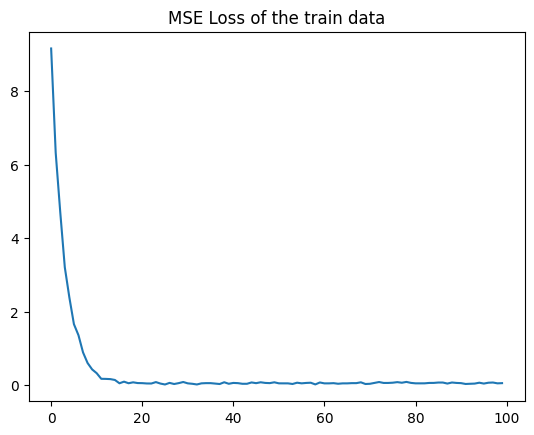

In [36]:
plt.title("MSE Loss of the train data")
loss_train_epoch_mean = np.array(loss_train_epoch_mean)
loss_train_epoch_std = np.array(loss_train_epoch_std)
plt.plot(loss_train_epoch_mean)
plt.fill_between(x=range(len(loss_train_epoch_mean)),y1=loss_train_epoch_mean+loss_train_epoch_std,y2=loss_train_epoch_mean-loss_train_epoch_std, alpha=0.5)
plt.show()

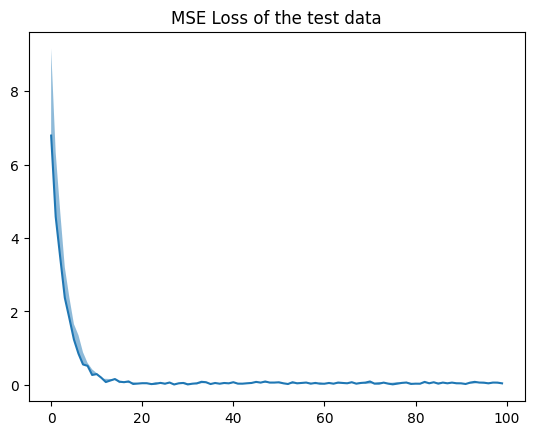

In [37]:
plt.title("MSE Loss of the test data")
loss_test_epoch_mean = np.array(loss_test_epoch_mean)
loss_test_epoch_std = np.array(loss_test_epoch_std)
plt.plot(loss_test_epoch_mean)
plt.fill_between(x=range(len(loss_test_epoch_mean)),y1=loss_test_epoch_mean+loss_test_epoch_std,y2=loss_train_epoch_mean-loss_train_epoch_std, alpha=0.5)
plt.show()

In [38]:
print("final MSE Loss:", loss_test_epoch_mean[-1])

final MSE Loss: 0.043483175337314606


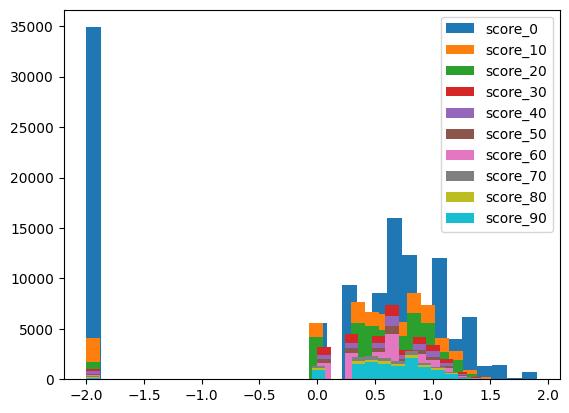

In [39]:
scores = data[['review_scores_rating', 'number_of_reviews']].dropna()
scores_ls = []
_min = 1
_max = 100
_step = 10

for i in range(_min, _max, _step):
    _score = scores[scores['number_of_reviews'] >= i]['review_scores_rating']
    _score = 100 - _score + 0.01
    _score = np.log10(_score)
    scores_ls.append(_score)
for i, score in enumerate(scores_ls):
    plt.hist(score, bins=30, label='score_' + str(i * _step))
plt.legend()
plt.show()

In [40]:
data['review_scores_rating'][data['review_scores_rating'] == 100].count()

34898

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.180e+02, 0.000e+00, 0.000e+00, 3.810e+03,
        0.000e+00, 1.892e+03, 3.015e+03, 0.000e+00, 3.884e+03, 2.313e+03,
        1.738e+03, 3.224e+03, 2.938e+03, 2.739e+03, 3.500e+03, 3.279e+03,
        2.983e+03, 3.583e+03, 3.958e+03, 3.317e+03, 3.781e+03, 3.052e+03,
        3.451e+03, 3.173e+03, 3.496e+03, 3.135e+03, 3.475e+03, 5.110e+03,
        3.087e+03, 3.204e+03, 3.218e+03, 3.213e+03, 3.310e+03, 3.867e+03,
        3.275e+03, 3.605e+03, 3.662e+03, 3.096e+03, 2.953e+03, 2.700e+03,
        2.178e+03, 1.761e+03, 1.182e+03, 8.900e+02, 6.430e+02, 4.840e+02,
        3.020e+02, 2.060e+02, 1.400e+02, 8.500e+01, 4.500e+01, 3.400e+01,
        3.000e+01, 1.700e+01, 1.500e+0

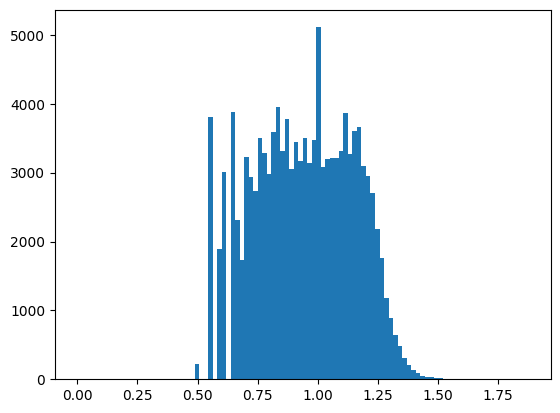

In [41]:
plt.hist(data['reviews_per_month'].dropna() ** 0.15, bins=100)

0         5.416100
1         4.488636
2         5.298317
3         4.094345
4         4.369448
            ...   
153249    5.010635
153250    5.003946
153251    5.236442
153252    7.003065
153253    6.109248
Name: price, Length: 153254, dtype: float64

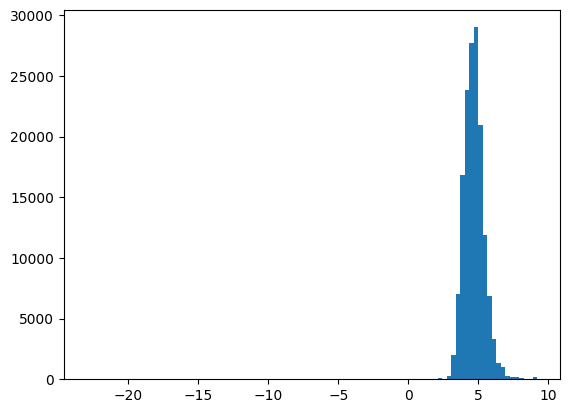

In [42]:
plt.hist(np.log(data['price'] + 1e-10), bins=100)


np.log(data['price'] + 1e-10)

(array([1.41010e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.09475e+05, 2.06310e+04, 8.57800e+03, 2.37000e+02, 1.20000e+01]),
 array([-18.42068074, -17.70517397, -16.9896672 , -16.27416043,
        -15.55865365, -14.84314688, -14.12764011, -13.41213333,
        -12.69662656, -11.98111979, -11.26561302, -10.55010624,
         -9.83459947,  -9.1190927 ,  -8.40358593,  -7.68807915,
         -6.97257238,  -6.25706561,  -5.54155883,  -4.82605206,
         -4.11054529,  -3.39503852,  -2.67953174,  -1.96402497,
         -1.2485182 ,  -0.53301143,   0.18249535,   0.89800212,
          1.61350889,   2.32901567,   3.04452244]),
 <BarContainer object of 30 artists>)

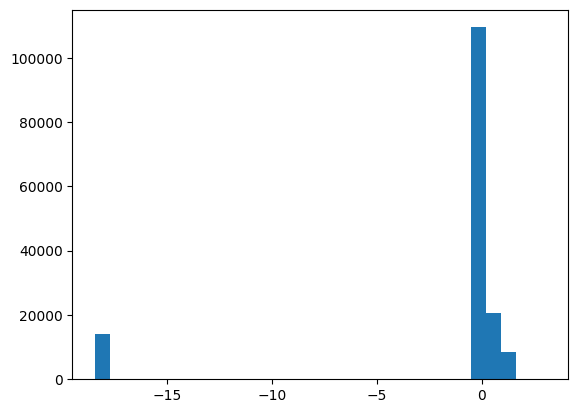

In [43]:
plt.hist(np.log(data['bedrooms']+1e-8), bins=30)

In [44]:
with open('columns.txt', 'wt') as f:
    for column in data_use.columns:
        f.write(column + '\n')

In [45]:
def get_user_input():
    property_type_list = data_use.columns[data_use.columns.str.contains('property_type_')].str.replace('property_type_', '')
    room_type_list = data_use.columns[data_use.columns.str.contains('room_type_')].str.replace('room_type_', '')
    bed_type_list  = data_use.columns[data_use.columns.str.contains('bed_type_')].str.replace('bed_type_', '')
    cancellation_policy_list = data_use.columns[data_use.columns.str.contains('cancellation_policy_')].str.replace('cancellation_policy_', '')
    for index, item in enumerate(property_type_list):
        print(f"property_type #{index}: {item}")
    print('\n\n\n\n\n')
    
    for index, item in enumerate(room_type_list):
        print(f"room type #{index}: {item}")
    print('\n\n\n\n\n')

    for index, item in enumerate(bed_type_list):
        print(f"bed type #{index}: {item}")
    print('\n\n\n\n\n')

    for index, item in enumerate(cancellation_policy_list):
        print(f"cancellation policy #{index}: {item}")
    print('\n\n\n\n\n')
    
    while(True):
        property_type = input('What is your property type? (0~39)')
        try:
            property_type = int(property_type)
        except TypeError:
            continue
        if(0 <= property_type <= 39):
            break
    
    while(True):
        room_type = input('what is your room type? (0~3)')
        try:
            room_type = int(room_type)
        except TypeError:
            continue
        if(0 <= room_type <= 3):
            break
    
    while(True):
        bed_type = input('what is your bed type? (0~4)')
        try:
            bed_type = int(bed_type)
        except TypeError:
            continue
        if(0 <= bed_type <= 4):
            break
    
    while(True):
        c_policy_type = input('what is your bed type? (0~5)')
        try:
            c_policy_type = int(c_policy_type)
        except TypeError:
            continue
        if(0 <= c_policy_type <= 5):
            break
    
    is_superhost          = (1 if input('Are you superhost?[y/n]')=='y' else 0)
    is_verified           = (1 if input('Did you verified yourself?[y/n]')=='y' else 0)
    is_location_exact     = input('Do you know what is the coordination of your room?[y/n]')
    if is_location_exact == 'y':
        latitude          = input('Latitude:')
        longitude         = input('Longitude:')
        location          = (float(latitude), float(longitude))
        is_location_exact = 1
    else:
        location          = input('What is your room address?')
        location          = Nominatim(user_agent='my_request').geocode(location)
        location          = (location.latitude, location.longitude)
        if location is None:
            print('Cannot find that location from Nominatim service, using default value instead...')
            location = (40.712781, -74.0060152)
        is_location_exact = 0
    accomodates           = float(input('accomodates?'))
    bathrooms             = float(input('number of bathrooms?'))
    bedrooms              = float(input('number of bedrooms?'))
    beds                  = float(input('number of beds?'))
    instant_bookable      = (1 if input('instant bookable?[y/n]')=='y' else 0)
    result = np.array([0.0 for _ in range(217)])
    result[property_type]    = 1
    result[40+room_type]     = 1
    result[44+bed_type]      = 1
    result[49+c_policy_type] = 1
    result[55]               = is_superhost
    result[56]               = is_verified
    result[57]               = location[0]
    result[58]               = location[1]
    result[59]               = is_location_exact
    result[60]               = accomodates
    result[61]               = bathrooms
    result[62]               = bedrooms
    result[63]               = beds
    result[67]               = instant_bookable
    
    return pd.DataFrame(result, index=data_use.columns).T

In [46]:
def predict_user_input(user_input, network, tokenizer):
    encoded, _ = tokenizer.encode(user_input)
    encoded = torch.FloatTensor(encoded).to(device)
    result  = network(encoded).cpu()
    return result

user_input = get_user_input()
#print(predict_user_input(user_input, network, tokenizer))

property_type #0: Aparthotel
property_type #1: Apartment
property_type #2: Barn
property_type #3: Bed and breakfast
property_type #4: Boat
property_type #5: Boutique hotel
property_type #6: Bungalow
property_type #7: Bus
property_type #8: Cabin
property_type #9: Camper/RV
property_type #10: Casa particular (Cuba)
property_type #11: Castle
property_type #12: Cave
property_type #13: Condominium
property_type #14: Cottage
property_type #15: Dome house
property_type #16: Dorm
property_type #17: Earth house
property_type #18: Farm stay
property_type #19: Guest suite
property_type #20: Guesthouse
property_type #21: Hostel
property_type #22: Hotel
property_type #23: House
property_type #24: Houseboat
property_type #25: In-law
property_type #26: Island
property_type #27: Lighthouse
property_type #28: Loft
property_type #29: Other
property_type #30: Resort
property_type #31: Serviced apartment
property_type #32: Tent
property_type #33: Timeshare
property_type #34: Tiny house
property_type #35: 

ValueError: Shape of passed values is (217, 1), indices imply (216, 1)

In [ ]:
#pd.options.display.max_rows = None 
encoded, _ = tokenizer.encode(user_input)
encoded = torch.FloatTensor(encoded).to(device)
result = network(encoded).cpu()
result = pd.DataFrame(result.detach(), columns=tokenizer.target)
#print(predict_user_input(user_input, network, tokenizer))

In [ ]:
data_use.columns[69:]

Index(['TV', 'Wifi', 'Air conditioning', 'Kitchen',
       'Paid parking off premises', 'Free street parking', 'Heating',
       'Family/kid friendly', 'Smoke detector', 'Carbon monoxide detector',
       ...
       'Bottled water', 'Mini fridge', 'Electric profiling bed',
       'Mobile hoist', 'Washer / Dryer', 'Pool with pool hoist',
       'Ceiling hoist', 'Record player', 'Turndown service', 'Snacks'],
      dtype='object', length=148)

In [ ]:
100 - (10 ** (result.review_scores_rating * 80 + 20)-1e-10)

0    99.999992
Name: review_scores_rating, dtype: float32

In [ ]:
tokenizer._minmax_scaler['price']

min       10.0
max    10000.0
Name: price, dtype: float64